# Week 6: Using scikit-learn for Naive Bayes and Logistic Regression

Things we have built painfully from scratch can be done easily and quickly using the ```scikit-learn``` module.

It can do the word-counting for us, transforming a column of tweets into a term-document matrix.

Then it can run classification, using a variety of algorithms.

```Scikit-learn``` can even do cross-validation automatically! Our lives are about to get a lot easier. 

(Of course, that means our goals can also become more ambitious.)

Let's start by reading in our handy dataset of Trump tweets. Then I'll simplify the dataframe to reduce the number of columns. I'll also create a "dummy" numeric column to represent the "class" each tweet belongs to, using the technique illustrated by Kevin Markham's linear regression notebook.


In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, math
import pandas as pd

cwd = os.getcwd()
print('Current working directory: ' + cwd + '\n')
      
relativepath = os.path.join('..', 'data', 'weekfour', 'trump.csv')
trump = pd.read_csv(relativepath)

def trump_test(a_data_frame, rowidx):
    ''' Just a function that translates complex statusSource strings
    into a simpler class label.
    '''
    
    if 'iphone' in a_data_frame['statusSource'][rowidx]:
        return 'iphone'
    elif 'android' in a_data_frame['statusSource'][rowidx]:
        return 'android'
    else:
        return 'other'

# Let's create a simple data frame with just two columns,
# the tweet text and the source.

tweet_text = trump['text']
source = []
for idx in trump.index:
    source.append(trump_test(trump, idx))

# We created source as a list. To add it to a data frame, we need
# to make it a Series, which is the Pandas way of thinking about
# an indexed list.
source = pd.Series(source, index = trump.index)

# Now let's create the Trump data frame.
tdf = pd.concat([tweet_text, source], axis = 1)
tdf.columns = ['text', 'source']

# Let's filter it to get rid of any rows that aren't iphone
# or android
tdf = tdf[(tdf['source'] == 'android') | (tdf['source'] == 'iphone')]

# Now to create a dummy numeric column. We'll need this later.
tdf['isandroid'] = tdf.source.map({'iphone':0, 'android':1})

tdf.head()

Current working directory: /Users/rdubnic2/Documents/lis590dsh/Code



,text,source,isandroid
0,My economic policy speech will be carried live...,android,1
1,"Join me in Fayetteville, North Carolina tomorr...",iphone,0
2,"#ICYMI: ""Will Media Apologize to Trump?"" https...",iphone,0
3,"Michael Morell, the lightweight former Acting ...",android,1
4,The media is going crazy. They totally distort...,android,1


### Using scikit-learn for word counting.

Classifiers are going to demand two arguments: 

A) a matrix where rows are observations and columns are variables.
B) a column of class labels for the observations.

For text classification, (A) is a document-term matrix. Fortunately ```scikit-learn``` has a ```CountVectorizer()``` function that can produce this automatically.

For full documentation, see:
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(max_features = 100)

# The max_features argument tells the vectorizer to return
# a matrix with columns for only the p most common words.

# Because this matrix could get quite large on a collection
# of long documents, the vectorizer returns it in a special
# 'sparse' format. But we're going to convert that to an ordinary
# DataFrame for ease of inspection and manipulation.

sparse_matrix = countvec.fit_transform(tdf['text'])
termdoc = pd.DataFrame(sparse_matrix.toarray(), columns=countvec.get_feature_names())
termdoc.head()


,about,again,all,am,america,amp,and,are,as,at,...,what,when,who,why,will,win,with,would,you,your
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
mnb = MultinomialNB()
scores = cross_val_score(mnb, termdoc.as_matrix(), tdf['isandroid'], cv=10)
print(sum(scores) / len(scores))
scores

0.799902661722


array([ 0.86428571,  0.8       ,  0.79856115,  0.77697842,  0.76978417,
        0.8057554 ,  0.81294964,  0.84172662,  0.81884058,  0.71014493])

### Regularized logistic regression

I won't fully explain logistic regression here. I hope I have time to sketch a little on the whiteboard. But very briefly, it's a way of *mapping* linear regression onto a finite space between 0 and 1. This allows a regression algorithm to do the work of classification. It is sometimes more accurate than naive Bayes. (More importantly, it produces well-*calibrated* probabilistic predictions. When logistic regression tells you an instance has a 60% chance of being in class X, that number is actually meaningful. Naive Bayes, on the other hand, has a tendency to exaggerate, seeing instances as all the way toward one class or the other.) 

*Regularizing* the regression basically means adding a degree of deliberate fuzz to prevent overfitting. This is done by penalizing large weights in the model (so your decision boundary can't become all volatile and wiggly.)

The upshot of all this is that regularized logistic regression gives you a parameter to tune: the regularization constant, ```C```, controlling the degree of fuzziness. In the scikit-learn implementation, small values of ```C``` mean strong (fuzzy) regularization.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = .1)
scores = cross_val_score(lr, termdoc.as_matrix(), tdf['isandroid'], cv=10)
print(sum(scores) / len(scores))
scores

0.827251664507


array([ 0.88571429,  0.82142857,  0.79856115,  0.82014388,  0.77697842,
        0.84892086,  0.86330935,  0.8705036 ,  0.81884058,  0.76811594])

## Homework exercise 1: grid search

Write a function that runs logistic regression repeatedly, in order to find the optimal value of C (regularization constant) for a given term-doc matrix and column of class labels. Use ten-fold cross-validation, as above.

For this problem, it makes sense to search the space between 30 and .0003. Try using this list of possible settings:
[30, 10, 3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, .0003]

Your function should return two values: the optimal parameter for C, and the accuracy achieved at the optimal parameter.

This is called "grid search" because you could, theoretically, optimize multiple parameters at once, with nested loops. Here, however, we're just optimizing one -- so it's more like "line search."

In [9]:
cvals = [30,10,3,1,0.3,0.1,0.03,0.01,0.003, 0.001,0.0003]
cvals

def opt_c_val_log(td_mat,col):
    from sklearn.linear_model import LogisticRegression
    cvals = [30,10,3,1,0.3,0.1,0.03,0.01,0.003, 0.001,0.0003]
    cdict = {}
    for i in cvals:
        lr = LogisticRegression(C = i)
        check = cross_val_score(lr,td_mat.as_matrix(), tdf[col], cv = 10)
        # above makes function only work for our Trump data frame, since you didn't say the function should take a data frame as a parameter
        cavg = sum(check)/len(check)
        cdict.update({i: cavg})
    # print(cdict)
    print('Optimal C Value: ', max(cdict, key=cdict.get),'\n Accuracy: ', cdict[max(cdict, key=cdict.get)])
    # I included a more human-readable output format, but it could be returned as just the key and value from the dictionary, or as tuple.

In [10]:
opt_c_val_log(termdoc, 'isandroid')

Optimal C Value:  0.3 
 Accuracy:  0.83736501482


## Homework exercise 2: battle of the algorithms

Which works better: logistic regression or naive Bayes?
Does it matter how many features we use?

Write a loop that generates term-doc matrices for the Trump dataset with different numbers of features, from 200 to 4000, increasing by 200 each time

```for i in range(200, 4200, 200):```

For each term-doc matrix, calculate the accuracy of naive Bayes, and also the accuracy of logistic regression (using your optimizer function from exercise 1 to get the best accuracy). Save both accuracies in a pair of growing lists.

When the loop is complete, plot the accuracy of both classifiers. The x axis should be ```number of features,``` the y axis should be ```accuracy```, and you should have two lines: one for naive Bayes, and one for logistic regression.

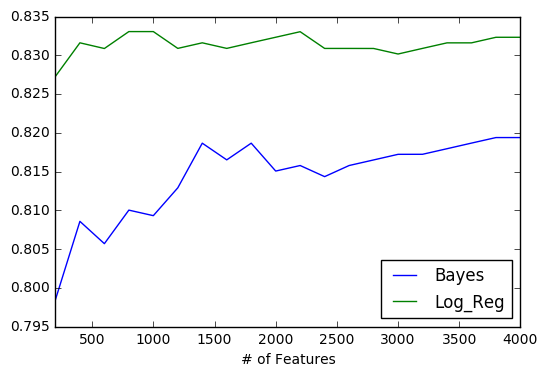

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

featlist = [num for num in range(200,4200, 200)]
# print(featlist)

bayes_list = []
log_list = []
for num in featlist:
    countvec = CountVectorizer(max_features = num)
    sparse_matrix = countvec.fit_transform(tdf['text'])
    termdoc = pd.DataFrame(sparse_matrix.toarray(), columns=countvec.get_feature_names())
    mnb = MultinomialNB()
    bayes_scores = cross_val_score(mnb, termdoc.as_matrix(), tdf['isandroid'], cv=10)
    bayes_acc = sum(bayes_scores) / len(bayes_scores)
    bayes_list.append(bayes_acc)
    # print('Bayes accuracy for',num,'features: ',bayes_acc)
    lr = LogisticRegression(C = .1)
    log_scores = cross_val_score(lr, termdoc.as_matrix(), tdf['isandroid'], cv=10)
    log_acc = sum(log_scores) / len(log_scores)
    log_list.append(log_acc)
    # print('Logistic Regression accuracy for',num,'features: ', log_acc)

# print(len(bayes_list))
# print(len(log_list))

# print(bayes_list)
# bayes_acc_array = np.array(bayes_list)
# print(bayes_acc_array)

# log_acc_array = np.array(log_list)

# bayes_scores
    
bayes_log = pd.DataFrame({'Bayes': bayes_list, 'Log_Reg': log_list, '# of Features': featlist})

bayes_log.plot(x='# of Features')


## Brief Analysis

As you can see, accuracy spiked for Bayes around a C value of 1,400, and for Log_Reg around 2,200. In the end, Log_REg was more accurate across different C values. I think we probably could've guessed this, but it's very interesting to see it play out and was helpful to go through the steps of testing two algorithms and creating a new dataframe out of the results.